Using device: mps
Model initialized. Model has 124,475,904 trainable parameters
Model loaded from gpt2_final.pth
Today is ________ for all those with asthma. Do you have asthma?
I know you use to have it


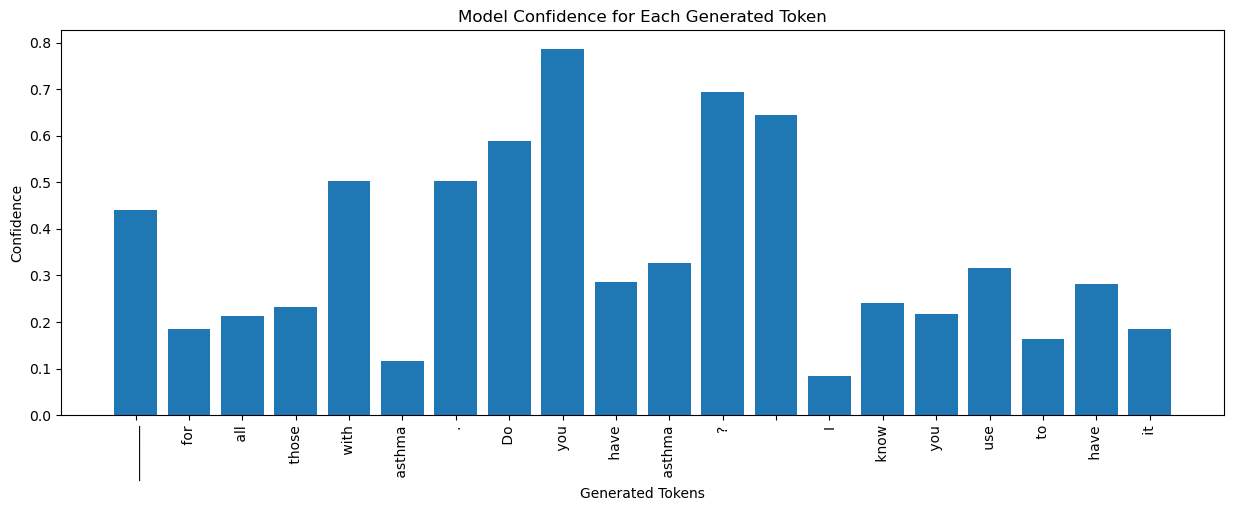

In [2]:
import torch
import tiktoken
from model import GPT, GPTConfig
import matplotlib.pyplot as plt
# ***************************#
# Device Configuration
# ***************************#
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")

print("Using device:", device)

# ***************************#
# Tokenizer Setup
# ***************************#
enc = tiktoken.get_encoding('gpt2')

# ***************************#
# Model Configuration
# ***************************#
gpt_config = GPTConfig(vocab_size=50304)
gpt = GPT(gpt_config, master_process=True).to(device)

# Load the saved model
model_path = "gpt2_final.pth"
gpt.load_state_dict(torch.load(model_path, map_location=device))

print(f"Model loaded from {model_path}")

# ***************************#
# Text Generation Function
# ***************************#
import torch

# Assuming `gpt.config.block_size` and `device` are defined elsewhere in the code.

# ***************************#
# Text Generation Function
# ***************************#
# ***************************#
# Text Generation Function
# ***************************#
def sample_from_logits(logits, top_k=50, temperature=1.0):
    if temperature != 1.0:
        logits = logits / temperature
    if top_k > 0:
        logits, indices = torch.topk(logits, top_k, dim=-1)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, 1)
        next_token = indices.gather(-1, next_token)
    else:
        probs = torch.nn.functional.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, 1)
    return next_token, probs

def generate_text(seed_text, model, enc, max_len=100, print_while_generating=True, show_probabilities=False):
    seed_length = len(enc.encode(seed_text))
    if print_while_generating:
        print(seed_text, end="")
    model.eval()
    with torch.no_grad():
        tokens = enc.encode(seed_text)
        if len(tokens) == 0:
            tokens = [enc.encode("<|endoftext|>", allowed_special={'<|endoftext|>'})[0]]
        all_probs = []
        for _ in range(max_len):
            x = torch.tensor(tokens[-model.config.block_size:], dtype=torch.long,
                             device=device).unsqueeze(0)
            logits, _ = model(x)
            next_token, probs = sample_from_logits(logits[:, -1, :])
            next_token = next_token[0].item()
            tokens.append(int(next_token))
            all_probs.append(probs.squeeze().cpu().numpy())
            if next_token == enc._special_tokens['<|endoftext|>']:
                break
            if print_while_generating:
                print(enc.decode([int(next_token)]), end="")
        print()

    if show_probabilities:
        plot_probabilities(tokens[seed_length:], all_probs, enc)

    return enc.decode(tokens)

def plot_probabilities(tokens, all_probs, enc):
    words = [enc.decode([token]) for token in tokens]
    confidences = [max(prob) for prob in all_probs]
    
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(words)), confidences)
    plt.xticks(range(len(words)), words, rotation='vertical')
    plt.xlabel('Generated Tokens')
    plt.ylabel('Confidence')
    plt.title('Model Confidence for Each Generated Token')
    plt.show()
# ***************************#
# Example Usage
# ***************************#

seed_text = "Today is "
generated_text = generate_text(seed_text, gpt, enc, max_len=20, print_while_generating=True, show_probabilities=True)


In [3]:
seed_text = "'Why did you leave me?', she asked. 'Because I don't"
generated_text = generate_text(seed_text, gpt, enc, max_len=1024, print_while_generating=True, show_probabilities=True)

'Why did you leave me?', she asked. 'Because I don't know you' answered Dora. We had no idea why I left me, you say.' There she was, sitting in a pool, holding hands and gazing at the pool.
Sandra asked questions like, Why am I here now? she said. 'I can't keep you down now because of that and, why? The water comes down and everything is suspended in the air and

KeyboardInterrupt: 

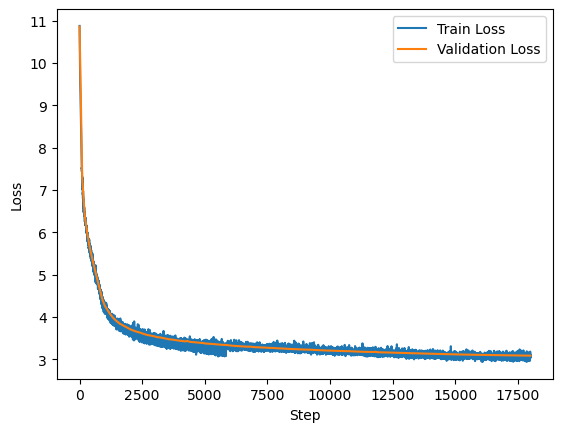

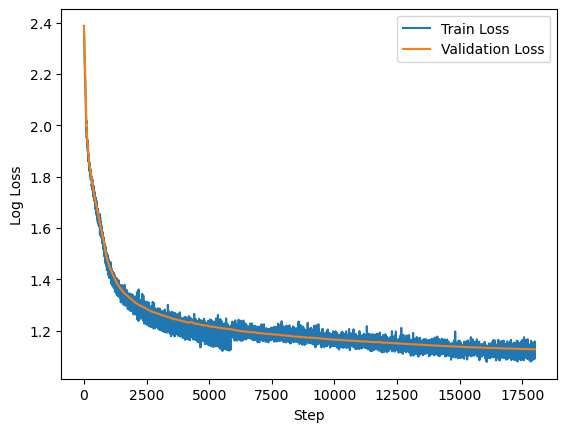

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plot = True
master_process = True
# load lossi and val lossi from /Users/mattia/Downloads/lossi_step_16000.pth (torch.load)
lossi = torch.load("lossi_final.pth")
val_lossi = torch.load("val_lossi_final.pth")

plt.plot(lossi, label="Train Loss")

# Stretch val_lossi to match the length of lossi
val_lossi_stretched = np.interp(
    np.linspace(0, len(val_lossi) - 1, len(lossi)),
    np.arange(len(val_lossi)),
    val_lossi
)

plt.plot(val_lossi_stretched, label="Validation Loss")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")

plt.show()

# we plot the log of the loss
plt.plot(np.log(lossi), label="Train Loss")
plt.plot(np.log(val_lossi_stretched), label="Validation Loss")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Log Loss")

plt.show()


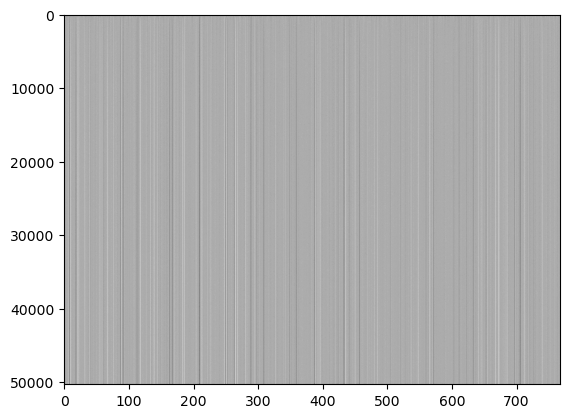

In [5]:
# Display the positional encoding weights in grey
import matplotlib.pyplot as plt
%matplotlib inline
state_dict = torch.load("gpt2_final.pth", map_location="cpu")
plt.imshow(state_dict["transformer.wte.weight"], cmap="Greys", aspect="auto")

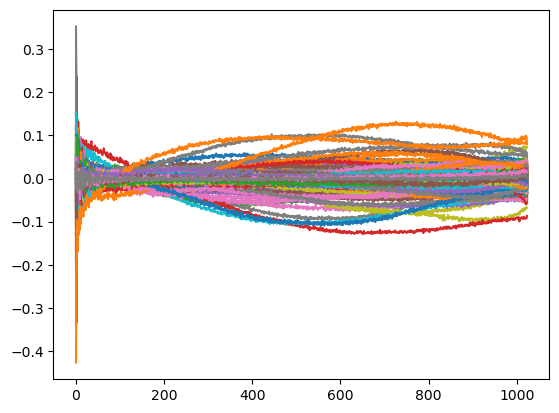

In [6]:
import matplotlib.pyplot as plt

def plot_wpe(num_columns = 768):
    for i in range(num_columns):
        plt.plot(state_dict["transformer.wpe.weight"][:, i].detach().numpy())
    plt.show()


plot_wpe()

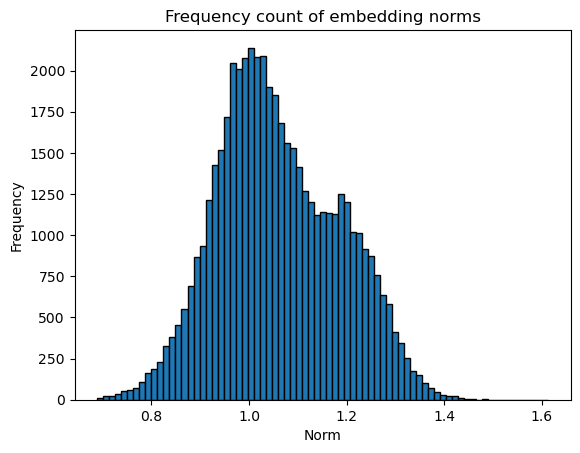

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_embedding_norms():
    # Compute the norms of the embeddings
    norms = torch.norm(state_dict["transformer.wte.weight"], dim=1).detach().numpy()
    
    # Create histogram bins and counts
    bin_count = 75  # Number of bins
    counts, bin_edges = np.histogram(norms, bins=bin_count)
    
    # Plot the histogram as a bar graph
    plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black')
    plt.xlabel("Norm")
    plt.ylabel("Frequency")
    plt.title("Frequency count of embedding norms")
    plt.show()

plot_embedding_norms()

thread '<unnamed>' panicked at src/lib.rs:201:64:
no entry found for key


PanicException: no entry found for key

/Users/mattia/miniconda3/envs/general_ml/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  func(*args, **kwargs)
/Users/mattia/miniconda3/envs/general_ml/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12527 (\N{KATAKANA LETTER WA}) missing from current font.
  func(*args, **kwargs)
/Users/mattia/miniconda3/envs/general_ml/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mattia/miniconda3/envs/general_ml/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12527 (\N{KATAKANA LETTER WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


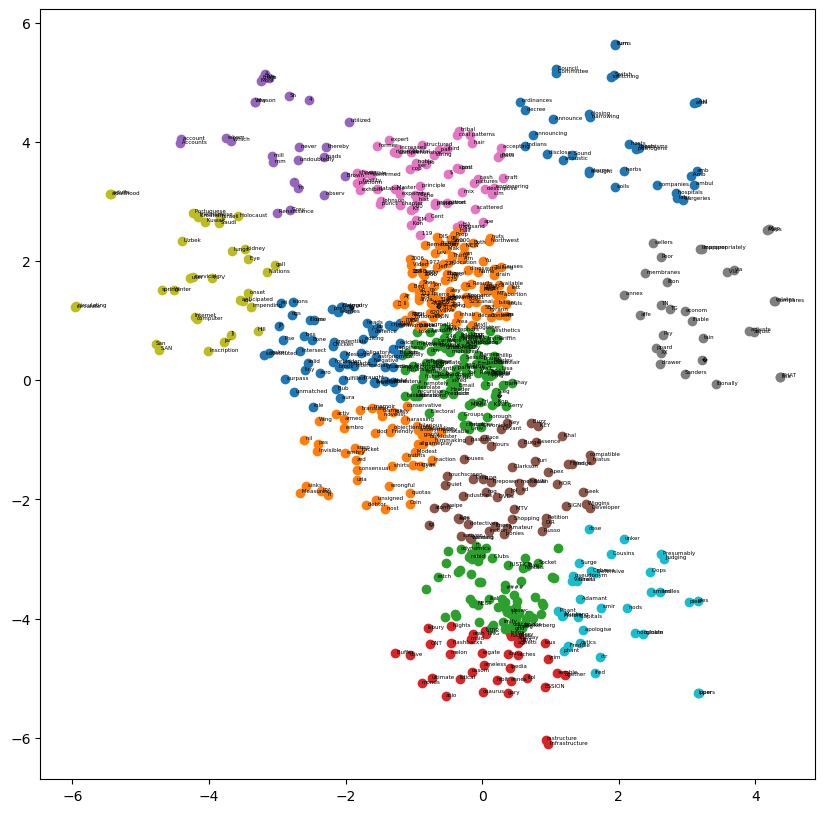

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

def index_to_token(index, enc):
    """Takes a single index and returns the corresponding token"""
    return enc.decode([index])

def cluster_and_plot_embeddings(state_dict, enc, num_embeddings=None, n_clusters=10):
    # Load the embeddings
    embeddings = state_dict["transformer.wte.weight"].detach().numpy()
    
    # Use random embeddings if num_embeddings is specified
    if num_embeddings:
        total_embeddings = embeddings.shape[0]
        random_indices = np.random.choice(total_embeddings, num_embeddings, replace=False)
        embeddings = embeddings[random_indices]
    else:
        random_indices = np.arange(embeddings.shape[0])
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(embeddings_2d)
    
    # Plot the embeddings with cluster labels and token labels
    plt.figure(figsize=(10, 10))
    for i in range(n_clusters):
        cluster_points = embeddings_2d[kmeans.labels_ == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}")
        for point, index in zip(cluster_points, np.where(kmeans.labels_ == i)[0]):
            token = index_to_token(random_indices[index], enc)
            plt.text(point[0], point[1], token, fontsize=4)
    
    plt.legend()
    plt.title("Embeddings after clustering")
    plt.show()



cluster_and_plot_embeddings(state_dict, enc, num_embeddings=1000, n_clusters=20)

In [ ]:
import torch

def find_closest_embedding(state_dict, enc, word1, word2, target_word):
    # Tokenize the input words
    token1 = enc.encode(word1)[0]
    token2 = enc.encode(word2)[0]
    target_token = enc.encode(target_word)[0]
    
    print(f"Tokenized words: {word1} -> {token1}, {word2} -> {token2}, {target_word} -> {target_token}")
    
    # Embed the tokenized words using the model's embedding layer
    embedding1 = state_dict["transformer.wte.weight"][token1]
    embedding2 = state_dict["transformer.wte.weight"][token2]
    target_embedding = state_dict["transformer.wte.weight"][target_token]
    
    print(f"Embeddings shapes: {word1} -> {embedding1.shape}, {word2} -> {embedding2.shape}, {target_word} -> {target_embedding.shape}")
    
    # Compute the difference between the two embeddings
    difference = embedding2 - embedding1
    #print(f"Difference between {word2} and {word1} embeddings: {difference}")
    
    # Add the difference to the embedding of the target word
    result_embedding = target_embedding + difference
    #print(f"Resulting embedding after adding the difference to {target_word}: {result_embedding}")
    
    # Normalize the result embedding for cosine similarity
    result_embedding = result_embedding / result_embedding.norm()
    
    # Find the closest word to the resulting embedding using cosine similarity
    embeddings = state_dict["transformer.wte.weight"]
    normalized_embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
    similarities = torch.matmul(normalized_embeddings, result_embedding)
    closest_word_token = similarities.argmax().item()
    closest_word = enc.decode([closest_word_token])
    
    print(f"The closest word to the resulting embedding is: {closest_word}")
    
    return closest_word

# Example 1: Gender Relations
closest_word_1 = find_closest_embedding(state_dict, enc, "king", "queen", "man")
print(f"king - man + woman = {closest_word_1}")

# Example 2: Verb Tenses
closest_word_2 = find_closest_embedding(state_dict, enc, "walk", "walking", "swimming")
print(f"walk - walking + swimming = {closest_word_2}")

# Example 3: Country-Capital Relations
closest_word_3 = find_closest_embedding(state_dict, enc, "paris", "france", "germany")
print(f"paris - france + germany = {closest_word_3}")

# Example 4: Comparative/Superlative
closest_word_4 = find_closest_embedding(state_dict, enc, "big", "bigger", "smaller")
print(f"big - bigger + smaller = {closest_word_4}")

# Example 5: Verb Conjugation
closest_word_5 = find_closest_embedding(state_dict, enc, "run", "ran", "swim")
print(f"run - ran + swim = {closest_word_5}")


Tokenized words: king -> 3364, queen -> 4188, man -> 805
Embeddings shapes: king -> torch.Size([768]), queen -> torch.Size([768]), man -> torch.Size([768])
The closest word to the resulting embedding is: que
king - man + woman = que
Tokenized words: walk -> 11152, walking -> 44065, swimming -> 2032
Embeddings shapes: walk -> torch.Size([768]), walking -> torch.Size([768]), swimming -> torch.Size([768])
The closest word to the resulting embedding is: sw
walk - walking + swimming = sw
Tokenized words: paris -> 1845, france -> 69, germany -> 1362
Embeddings shapes: paris -> torch.Size([768]), france -> torch.Size([768]), germany -> torch.Size([768])
The closest word to the resulting embedding is: ger
paris - france + germany = ger
Tokenized words: big -> 14261, bigger -> 14261, smaller -> 17470
Embeddings shapes: big -> torch.Size([768]), bigger -> torch.Size([768]), smaller -> torch.Size([768])
The closest word to the resulting embedding is: small
big - bigger + smaller = small
Tokenized